# Detecting brain tumor in MRI images
The project is about classfiing patiants into two groups. The groups are about having a tumor in the brain or not. The data is gathered from about 300 patiants and they are 300 MRI images from 300 distinct pationts(Dataset: [Brain MRI images for brain tumor detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)). Images are labled as containing tumor ('YES') and healthy ('NO'). Our duty is to learn these data and be able to classify unseen data accuratly.


First of all let's include all the necessary things.

In [2]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

After that we need to load the dataset. The dataset consists of two separate folders named as *train* and *test* which containing training and test data respectivly. Each folder has two categories that are labeled as *YES* and *NO* meaning beaing healthy and having a tumor respectively.

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


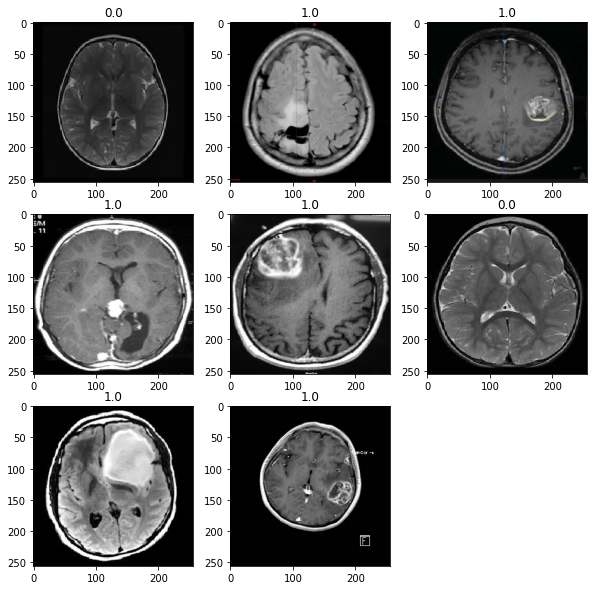

In [8]:
train_data_path = './data/train/'
test_data_path = './data/test/'

datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train = datagen.flow_from_directory(train_data_path, class_mode='binary', batch_size=8)
test = datagen.flow_from_directory(test_data_path, class_mode='binary', batch_size=8)

batchX, batchy = train.next()

plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(3,3,i+1)
    plt.imshow(np.array(batchX[i], dtype=np.uint8))
    plt.title(batchy[i])
plt.show()